In [1]:
from PIL import Image
import depth_pro

In [2]:
# Load model and preprocessing transform
model, transform = depth_pro.create_model_and_transforms()
model.eval()

DepthPro(
  (encoder): DepthProEncoder(
    (patch_encoder): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linea

In [24]:
# Load and preprocess an image.
image, _, f_px = depth_pro.load_rgb('data/frame_009.png')
image = transform(image)

# Run inference.
prediction = model.infer(image, f_px=f_px)
depth = prediction["depth"]  # Depth in [m].
focallength_px = prediction["focallength_px"]  # Focal length in pixels.

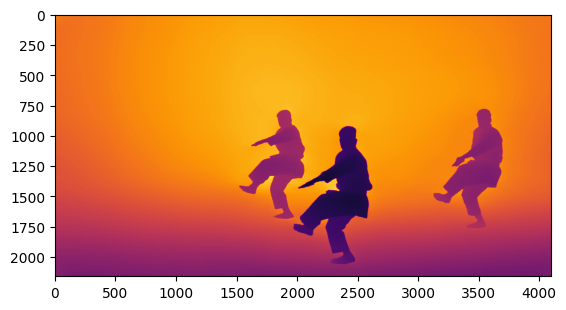

In [25]:
import matplotlib.pyplot as plt

plt.imshow(depth, cmap='inferno')

In [26]:
depth_numpy = depth.cpu().numpy()
depth_numpy

array([[13.42633 , 13.806628, 16.63347 , ..., 19.913445, 18.681305,
        18.49062 ],
       [17.93907 , 18.213678, 20.055729, ..., 21.391167, 21.040213,
        20.98284 ],
       [23.791374, 23.764597, 23.605196, ..., 22.577448, 22.94071 ,
        23.002392],
       ...,
       [18.06663 , 18.06245 , 18.037426, ..., 17.283897, 17.34104 ,
        17.350601],
       [16.385809, 16.479969, 17.06847 , ..., 15.747857, 14.868693,
        14.73162 ],
       [14.458821, 14.641344, 15.841185, ..., 13.995951, 12.372387,
        12.137719]], dtype=float32)

In [41]:
import numpy as np

def depth_to_pcd(depth, focallength_px):
    # Convert depth map to 3D point cloud
    # Create 3D grid

    img_h, img_w = depth.shape
    x, y = np.meshgrid(np.arange(img_w), np.arange(img_h))
    x = x.flatten()
    y = img_h - y.flatten() # flip y to match the image coordinate system
    z = depth.flatten() * 200

    return np.vstack([x, y, z])

In [42]:
Xs = depth_to_pcd(depth_numpy, focallength_px)
Xs.shape

(3, 8847360)

In [43]:
import cv2

img_ori = cv2.imread('data/frame_009.png')
img_ori = cv2.cvtColor(img_ori, cv2.COLOR_BGR2RGB)
colors = img_ori.flatten().reshape(-1, 3)

In [44]:
import open3d as o3d

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(Xs.T)
pcd.colors = o3d.utility.Vector3dVector(colors/255.0)
o3d.io.write_point_cloud(f"frame_009_depthpro.ply", pcd)
#print(pcd)
o3d.visualization.draw_geometries([pcd])